In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

# DataLoader

In [2]:
# dataset
class Dataset(Dataset):
  
    def __init__(self):
        'Initialization'
        
    def __len__(self):
        'Denotes the total number of samples'
        return 1200
        #return 6 #for testing code
    
    def __getitem__(self, index):
        'Generates one sample of data'
        
        # Load data
        X = torch.load('data/true_data/{}.pt'.format(index))
        return X

In [3]:
BATCH_SIZE = 20

In [4]:
from sklearn.model_selection import train_test_split
dataset = Dataset()
train_index, valid_index = train_test_split(range(len(dataset)), test_size=0.2)
train_data = Subset(dataset,train_index)
valid_data = Subset(dataset,valid_index)
dataloader_train = DataLoader(dataset = train_data, batch_size=BATCH_SIZE,
                                         shuffle=True)
dataloader_valid = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE,shuffle=False)#こっちは学習に使ってない
# Grab a batch of real images from the dataloader
"""real_batch = next(iter(dataloader_valid))

# Plot the real images
plt.axis("off")
plt.title("Real Images")
print(real_batch[15][0].shape)
plt.imshow(real_batch[15][0])
plt.colorbar()
plt.show()"""

'real_batch = next(iter(dataloader_valid))\n\n# Plot the real images\nplt.axis("off")\nplt.title("Real Images")\nprint(real_batch[15][0].shape)\nplt.imshow(real_batch[15][0])\nplt.colorbar()\nplt.show()'

# Model

In [5]:

class Self_Attention(nn.Module):
    """
    #Self-AttentionのLayer
    """
    def __init__(self,in_dim):
        super(Self_Attention,self).__init__()#不明
        #i*1の畳み込み層によるpointwise convolutionを用意
        self.query_conv=nn.Conv2d(
            in_channels=in_dim,out_channels=in_dim//8,kernel_size=1)#Conv2dを生成画像サイズ確認
        self.key_conv=nn.Conv2d(
            in_channels=in_dim,out_channels=in_dim//8,kernel_size=1)#Conv2dを生成
        self.value_conv=nn.Conv2d(
            in_channels=in_dim,out_channels=in_dim,kernel_size=1)#Conv2dを生成)
        #AttentionMap用の正規化softmax
        self.softmax=nn.Softmax(dim=-2)
        #入力xとAttentionMapを足すときの係数
        self.gamma=nn.Parameter(torch.zeros(1))
    
    def forward(self,x):
        #入力
        X=x
        #畳み込みをしてからサイズ変更B,C',W,H->B,C',N
        proj_query=self.query_conv(x).view(
            X.shape[0],-1,X.shape[2]*X.shape[3])#サイズB,C',N
        proj_query=proj_query.permute(0,2,1)#転置#サイズ　B,N,C'
        proj_key=self.key_conv(x).view(
            X.shape[0],-1,X.shape[2]*X.shape[3])#サイズB,C',N
        #かけざん
        S=torch.bmm(proj_query,proj_key)#サイズB,N,N
        
        #規格化
        attention_map_T=self.softmax(S)#正規化
        attention_map=attention_map_T.permute(0,2,1)#サイズ:B,N,N(?)#出力しないから転置不要
        #Attentionmapを計算
        proj_value=self.value_conv(X).view(
            X.shape[0],-1,X.shape[2]*X.shape[3])#サイズB,C,N
        #o=torch.bmm(proj_value,attention_map_T.permute)
        o=torch.bmm(proj_value,attention_map.permute(0,2,1))#出力しないから転置不要
        
        #AttentionmapのoのテンソルサイズをXにそろえる->計算
        o=o.view(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
        out=x+self.gamma*o
        return out #,attention_map#attention_mapは学習には不要

In [6]:
# Generator
# Generator Code
#attention2を使うとメモリ消費が激しいため除いています。使う場合は######3の部分をコメントアウトを解除してください
#どうもいつも同じ画像になるようです(loss=1.6636)
#これはlrのせいなのか構造上の問題なのか、使用データの問題なのかは不明
#一度生成器側を二つに分割して3つを育てるという考え方にシフトしてみてもいいかも(3つ中2つを使って学習させる)(dropoutの利用も検討)
class Generator(nn.Module):
    def __init__(self,nz=20,DIM=64):#今のところ入力は[1,20,5,4]
        super(Generator, self).__init__()
        self.layer2_sub=nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( nz, DIM * 16, kernel_size=4, stride=2, padding=0, bias=False)),
            nn.BatchNorm2d(DIM * 16),
            nn.ReLU(inplace=True))
        self.self_attention1 = Self_Attention(in_dim=DIM * 16)
        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( DIM * 16, DIM * 8, kernel_size=4, stride=3, padding=(2,1), bias=False)),
            nn.BatchNorm2d(DIM * 8),
            nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( DIM * 8, DIM * 4, kernel_size=(3,4), stride=3, padding=(2,1), bias=False)),
            nn.BatchNorm2d(DIM * 4),
            nn.ReLU(inplace=True))
        #かなりやばい学習方法を使う#入力の形を適度に決める
        self.layer5 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( DIM * 4, DIM * 2, kernel_size=3, stride=2, padding=0, bias=False)),
            nn.BatchNorm2d(DIM * 2),
            nn.ReLU(inplace=True))
        #self.self_attention2 = Self_Attention(in_dim=DIM*2)######3
        self.layer6 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( DIM * 2, DIM, kernel_size=(4,2), stride=2, padding=(2,0), bias=False)),
            nn.BatchNorm2d(DIM),
            nn.ReLU(inplace=True))
        self.layer7 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( DIM, 1, kernel_size=(4,3), stride=2, padding=0, bias=False)),
            nn.Tanh()   
        )
    def forward(self, x):
        out=self.layer2_sub(x)
        out=self.self_attention1(out)#10*10
        out=self.layer3(out)
        #out = self.layer3_sub(x)#5*5
        
        out = self.layer4(out)#10*10
        out = self.layer5(out)
        #out=self.self_attention2(out)#10*10
        out = self.layer6(out)
        out = self.layer7(out)
        return out
    def sample_latent(self,num_samples):
        return torch.randn((num_samples,nz,1,1))

In [7]:
#識別器4層
#DCGANでありSAGANではないメモリ節約、後日改良
#image_size->DIM
#SA層はこっちはなくしたほうがいいかも
#z_dim->nz
class Discriminator(nn.Module):
    def __init__(self,DIM=64):#nz不要説
        super(Discriminator,self).__init__()
        #1層:真画像、偽画像->image_size
        #input=1,330,261
        self.layer1=nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1,DIM,kernel_size=4,stride=3,padding=1, bias=False)),#input1,output64
            nn.LeakyReLU(0.2,inplace=True))
        #2層:image_size->image_size*2
        self.layer2=nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d( DIM, DIM*2, kernel_size=4, stride=3, padding=(0,1), bias=False)),#input1,output64
            nn.LeakyReLU(0.2,inplace=True))
        #3層:image_size*2->image_size*4
        self.layer3=nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(DIM * 2, DIM * 4, kernel_size=4, stride=3, padding=(0,1), bias=False)),#input1,output64
            nn.LeakyReLU(0.2,inplace=True))
        #self.self_attention1 = Self_Attention(in_dim=DIM * 4)
        #4層:image_size*4->image_size*8
        self.layer4=nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(DIM * 4, DIM * 8, kernel_size=4, stride=3, padding=(0,1), bias=False)),#input1,output64
            nn.LeakyReLU(0.2,inplace=True))
        #最終層:image_size*8->真偽
        self.last=nn.utils.spectral_norm(nn.Conv2d(DIM * 8,1, kernel_size=3, stride=1, padding=0, bias=False))
    
    def forward(self,x):#層を増やすときはここも変更すること#ある意味ここはfor文+辞書処理でもいいかもね
        #print(x.shape)#[1, 1, 330, 261]
        out=self.layer1(x)
        #print(out.shape)#[1, 64, 110, 87]
        out=self.layer2(out)
        #print(out.shape)#[1, 128, 54, 44]
        out=self.layer3(out)
        #print(out.shape)#[1,256,26,15]
        #out=self.self_attention1(out)
        out=self.layer4(out)
        #print(out.shape)#[1,512,8,5]
        out=self.last(out)
        #print(out.shape)#[1,1,5,4]
        return out

In [8]:
G=Generator(nz=20,DIM=64)
input_z=torch.randn(1,40)#テンソル(1,20)
input_z=input_z.view(1,20,2,1)
fake_images=G(input_z)
print(fake_images.shape)

torch.Size([1, 1, 330, 261])


In [9]:
D=Discriminator(DIM=64)####################

d_out=D(fake_images)
print(d_out.shape)
print(nn.Sigmoid()(d_out))#

torch.Size([1, 1, 1, 1])
tensor([[[[0.5094]]]], grad_fn=<SigmoidBackward>)


In [10]:
a=dataloader_train.batch_size
print(a)

20


torch.Size([1, 1, 330, 261])


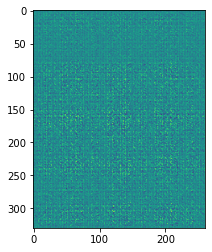

0.08074450492858887
11966337


In [11]:

import matplotlib.pyplot as plt
import time
%matplotlib inline

#G = Generator(nz=20, DIM=64)

# 入力する乱数
input_z = torch.randn(1, 40)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(1, 20, 2, 1)

# 偽画像を出力
start=time.time()
fake_images= G(input_z)
end=time.time()
print(fake_images.shape)
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed)
plt.show()

print(end-start)
#params_D = 0
params_G=0
#for p in D.parameters():
    #if p.requires_grad:
        #params_D += p.numel()
for p in G.parameters():
    if p.requires_grad:
        params_G += p.numel()
#print((13465803+14664877)/(3173251+2946099))
#print(params_D)  # 121898
print(params_G)

#"""

In [12]:
for i in range(10):
    i+=1
    print(i)

1
2
3
4
5
6
7
8
9
10


In [13]:
def train_model(G,D,dataloader,num_epochs,Lt_his={}):#ラベルミスあるかも
    #GPU確認
    if Lt_his=={}:
        history={}
        history["generator_loss_values"]=[]
        history["discriminator_loss_values"]=[]
    else:
        history=Lt_his
    #images_for_check=[]#メモリ不足
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス:", device)
    
    g_lr=0.004#学習率が大きすぎてダメかも
    d_lr=0.001#学習率
    beta1=0.0
    beta2=0.9
    g_optimizer=torch.optim.Adam(G.parameters(),g_lr,[beta1,beta2])
    d_optimizer=torch.optim.Adam(D.parameters(),d_lr,[beta1,beta2])
    
    #損失関数を定義
    criterion=nn.BCEWithLogitsLoss(reduction="mean")
    
    #パラメータをハードコーディング
    nz=20
    mini_batch_size=5
    
    #ネットワークをGPUへ
    G.to(device)
    D.to(device)
    
    G.train()#モデルを訓練モードに
    D.train()#モデルを訓練モードに
    
    #ネットワークがある程度固定であれば高速化させる
    torch.backends.cudnn.benchmark=True
    
    #画像の枚数
    num_train_imgs=len(dataloader.dataset)
    batch_size=dataloader.batch_size
    
    #イテレーションカウンタをセット
    iteration=1
    logs=[]
    
    #epochのループ
    for epoch in range(num_epochs):
        #開始時刻を保持
        t_epoch_start=time.time()
        epoch_g_loss=0.0
        epoch_d_loss=0.0
        #print("---")
        print("Epoch{}/{}".format(epoch,num_epochs))
        #print("---")
        #print("(train)")
        
        #データローダーからminibatchずつ取り出す
        for imges in dataloader:#
            #1:Discriminatorの学習
            #minibatchサイズ1だとバッチノーマライゼーションでエラー発生
            if imges.size()[0]==1:
                continue
            #GPU使用できるときGPUに流す
            imges=imges.to(device)
            
            #ラベル作成#下に修正作業あり
            mini_batch_size=imges.size()[0]
            label_real=torch.full((mini_batch_size,),1).to(device)
            label_fake=torch.full((mini_batch_size,),0).to(device)
            
            #真画像判定
            d_out_real=D(imges)
            
            #偽画像生成&判定##################################################入力を[1,20,5,4]に設定しています
            input_z=torch.randn(mini_batch_size,nz*2).to(device)
            input_z=input_z.view(mini_batch_size,nz,2,1)#テンソルの形を変更
            fake_images=G(input_z)#偽画像生成
            d_out_fake=D(fake_images)#偽画像判定
            
            #誤差を計算
            #修正あり詳しくは->"https://github.com/YutaroOgawa/pytorch_advanced/issues/144"
            label_real=label_real.type_as(d_out_real.view(-1))
            d_loss_real=criterion(d_out_real.view(-1),label_real)
            label_fake=label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake=criterion(d_out_fake.view(-1),label_fake)
            d_loss=d_loss_real+d_loss_fake
            
            #誤差逆伝播
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            #print("ここまでOK")
            #2:Generatorの学習
            #偽画像生成&判定
            input_z=torch.randn(mini_batch_size,nz*2).to(device)#minibatch個のz_dim生成->GPUへ
            input_z=input_z.view(mini_batch_size,nz,2,1)#テンソルの形を変更
            fake_images=G(input_z)#偽画像生成
            d_out_fake=D(fake_images)#偽画像判定
            
            #誤差を計算
            #修正あり詳しくは->"https://github.com/YutaroOgawa/pytorch_advanced/issues/144"
            """label_real=label_real.type_as(d_out_real.view(-1))"""#計算でエラーが出たらここを変更
            g_loss=criterion(d_out_fake.view(-1),label_real)
            
            
            #誤差逆伝播
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            g_loss.backward()
            g_optimizer.step()
            
            #3:記録
            epoch_d_loss+=d_loss.item()
            epoch_g_loss+=g_loss.item()
            iteration+=1
        
        #epochのphaseごとのlossと正答率
        t_epoch_finish=time.time()
        #print("---")
        print("epoch{}||Epoch_D_Loss:{:.4f}||Epoch_G_Loss:{:.4f}".format(epoch,epoch_d_loss/batch_size,epoch_g_loss/batch_size))
        print("timer:{:.4f}sec.".format(t_epoch_finish-t_epoch_start))
        time.sleep(2)#GPUの温度を下げる目的
        t_epoch_start=time.time()
        if epoch%100==50:
            time.sleep(5)
        if epoch%1000==500:
            time.sleep(20)
        history["generator_loss_values"].append(epoch_g_loss)
        history["discriminator_loss_values"].append(epoch_d_loss)
        """
        if epoch%(num_epochs//3)==(num_epochs//6):
            input_z_check=torch.randn(mini_batch_size,nz*1).to(device)#minibatch個のz_dim生成->GPUへ
            input_z_check=input_z_check.view(mini_batch_size,nz,1,1)#テンソルの形を変更
            fake_images=G(input_z_check)#偽画像生成
            images_for_check.append(fake_images[0])
        #メモリが圧倒的に足りません
        if epoch_d_loss<batch_size*1.66365 and epoch_d_loss>batch_size*1.66355:
            if epoch_g_loss<batch_size*1.66365 and epoch_g_loss>batch_size*1.66355:
                break
                
        """
    return G,D,history

In [14]:
"""
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")
"""

'\n# ネットワークの初期化\ndef weights_init(m):\n    classname = m.__class__.__name__\n    if classname.find(\'Conv\') != -1:\n        # Conv2dとConvTranspose2dの初期化\n        nn.init.normal_(m.weight.data, 0.0, 0.02)\n        nn.init.constant_(m.bias.data, 0)\n    elif classname.find(\'BatchNorm\') != -1:\n        # BatchNorm2dの初期化\n        nn.init.normal_(m.weight.data, 1.0, 0.02)\n        nn.init.constant_(m.bias.data, 0)\n\n\n# 初期化の実施\nG.apply(weights_init)\nD.apply(weights_init)\n\nprint("ネットワークの初期化完了")\n'

In [15]:
##### 学習
#100か1000かは何でもよいが画像を生成して保存しておくのも一つ進捗確認で必要やもしれん




#history={}
num_epochs=1000#回数を指定
G_update,D_update,history=train_model(
    G,D,dataloader=dataloader_train,num_epochs=num_epochs,Lt_his=history)

使用デバイス: cuda:0
Epoch0/1000
epoch0||Epoch_D_Loss:3.2212||Epoch_G_Loss:1.7285
timer:12.9341sec.
Epoch1/1000
epoch1||Epoch_D_Loss:1.8577||Epoch_G_Loss:1.9444
timer:6.8124sec.
Epoch2/1000
epoch2||Epoch_D_Loss:2.0344||Epoch_G_Loss:1.7961
timer:6.7164sec.
Epoch3/1000
epoch3||Epoch_D_Loss:2.0595||Epoch_G_Loss:1.8143
timer:6.8155sec.
Epoch4/1000
epoch4||Epoch_D_Loss:1.8868||Epoch_G_Loss:1.8905
timer:6.8529sec.
Epoch5/1000
epoch5||Epoch_D_Loss:2.2318||Epoch_G_Loss:1.6739
timer:6.7015sec.
Epoch6/1000
epoch6||Epoch_D_Loss:2.6792||Epoch_G_Loss:1.6988
timer:6.7310sec.
Epoch7/1000
epoch7||Epoch_D_Loss:2.7201||Epoch_G_Loss:1.6561
timer:6.7358sec.
Epoch8/1000
epoch8||Epoch_D_Loss:2.5003||Epoch_G_Loss:1.7522
timer:6.7335sec.
Epoch9/1000
epoch9||Epoch_D_Loss:2.4255||Epoch_G_Loss:1.7082
timer:6.7510sec.
Epoch10/1000
epoch10||Epoch_D_Loss:2.3418||Epoch_G_Loss:1.7257
timer:6.7793sec.
Epoch11/1000
epoch11||Epoch_D_Loss:2.2363||Epoch_G_Loss:1.7120
timer:6.7943sec.
Epoch12/1000
epoch12||Epoch_D_Loss:2.1469||E

Epoch103/1000
epoch103||Epoch_D_Loss:1.8825||Epoch_G_Loss:1.6679
timer:6.8018sec.
Epoch104/1000
epoch104||Epoch_D_Loss:1.8785||Epoch_G_Loss:1.6724
timer:6.7928sec.
Epoch105/1000
epoch105||Epoch_D_Loss:1.8869||Epoch_G_Loss:1.6721
timer:6.8249sec.
Epoch106/1000
epoch106||Epoch_D_Loss:1.9031||Epoch_G_Loss:1.6764
timer:6.8437sec.
Epoch107/1000
epoch107||Epoch_D_Loss:1.8918||Epoch_G_Loss:1.6760
timer:6.8197sec.
Epoch108/1000
epoch108||Epoch_D_Loss:1.8900||Epoch_G_Loss:1.6778
timer:6.8048sec.
Epoch109/1000
epoch109||Epoch_D_Loss:1.8947||Epoch_G_Loss:1.6724
timer:6.8028sec.
Epoch110/1000
epoch110||Epoch_D_Loss:1.9028||Epoch_G_Loss:1.6684
timer:6.8068sec.
Epoch111/1000
epoch111||Epoch_D_Loss:1.9026||Epoch_G_Loss:1.6676
timer:6.8107sec.
Epoch112/1000
epoch112||Epoch_D_Loss:1.9135||Epoch_G_Loss:1.6692
timer:6.8128sec.
Epoch113/1000
epoch113||Epoch_D_Loss:1.9183||Epoch_G_Loss:1.6616
timer:6.8098sec.
Epoch114/1000
epoch114||Epoch_D_Loss:1.9258||Epoch_G_Loss:1.6588
timer:6.8008sec.
Epoch115/1000
ep

Epoch203/1000
epoch203||Epoch_D_Loss:1.9885||Epoch_G_Loss:1.6858
timer:6.8367sec.
Epoch204/1000
epoch204||Epoch_D_Loss:1.9863||Epoch_G_Loss:1.6794
timer:6.8347sec.
Epoch205/1000
epoch205||Epoch_D_Loss:1.9728||Epoch_G_Loss:1.6855
timer:6.8068sec.
Epoch206/1000
epoch206||Epoch_D_Loss:1.9655||Epoch_G_Loss:1.6858
timer:6.8279sec.
Epoch207/1000
epoch207||Epoch_D_Loss:1.9937||Epoch_G_Loss:1.6647
timer:6.8038sec.
Epoch208/1000
epoch208||Epoch_D_Loss:2.0038||Epoch_G_Loss:1.6670
timer:6.8197sec.
Epoch209/1000
epoch209||Epoch_D_Loss:1.9907||Epoch_G_Loss:1.6684
timer:6.8088sec.
Epoch210/1000
epoch210||Epoch_D_Loss:2.0018||Epoch_G_Loss:1.6676
timer:6.8048sec.
Epoch211/1000
epoch211||Epoch_D_Loss:2.0107||Epoch_G_Loss:1.6640
timer:6.8068sec.
Epoch212/1000
epoch212||Epoch_D_Loss:2.0127||Epoch_G_Loss:1.6664
timer:6.8018sec.
Epoch213/1000
epoch213||Epoch_D_Loss:2.0051||Epoch_G_Loss:1.6693
timer:6.8267sec.
Epoch214/1000
epoch214||Epoch_D_Loss:2.0164||Epoch_G_Loss:1.6591
timer:6.8170sec.
Epoch215/1000
ep

Epoch303/1000
epoch303||Epoch_D_Loss:2.1779||Epoch_G_Loss:1.6585
timer:6.8207sec.
Epoch304/1000
epoch304||Epoch_D_Loss:2.1619||Epoch_G_Loss:1.6753
timer:6.8207sec.
Epoch305/1000
epoch305||Epoch_D_Loss:2.1393||Epoch_G_Loss:1.6946
timer:6.8457sec.
Epoch306/1000
epoch306||Epoch_D_Loss:2.1698||Epoch_G_Loss:1.6714
timer:6.8363sec.
Epoch307/1000
epoch307||Epoch_D_Loss:2.1338||Epoch_G_Loss:1.6857
timer:6.8208sec.
Epoch308/1000
epoch308||Epoch_D_Loss:2.1202||Epoch_G_Loss:1.7096
timer:6.8279sec.
Epoch309/1000
epoch309||Epoch_D_Loss:2.1381||Epoch_G_Loss:1.6762
timer:6.8372sec.
Epoch310/1000
epoch310||Epoch_D_Loss:2.1313||Epoch_G_Loss:1.6721
timer:6.8486sec.
Epoch311/1000
epoch311||Epoch_D_Loss:2.1316||Epoch_G_Loss:1.6764
timer:6.8327sec.
Epoch312/1000
epoch312||Epoch_D_Loss:2.1335||Epoch_G_Loss:1.6751
timer:6.8228sec.
Epoch313/1000
epoch313||Epoch_D_Loss:2.1384||Epoch_G_Loss:1.6663
timer:6.8357sec.
Epoch314/1000
epoch314||Epoch_D_Loss:2.1716||Epoch_G_Loss:1.6440
timer:6.8646sec.
Epoch315/1000
ep

Epoch403/1000
epoch403||Epoch_D_Loss:2.2450||Epoch_G_Loss:1.6718
timer:6.7629sec.
Epoch404/1000
epoch404||Epoch_D_Loss:2.2433||Epoch_G_Loss:1.6611
timer:6.7749sec.
Epoch405/1000
epoch405||Epoch_D_Loss:2.2617||Epoch_G_Loss:1.6634
timer:6.7759sec.
Epoch406/1000
epoch406||Epoch_D_Loss:2.2501||Epoch_G_Loss:1.6608
timer:6.8038sec.
Epoch407/1000
epoch407||Epoch_D_Loss:2.2664||Epoch_G_Loss:1.6301
timer:6.7789sec.
Epoch408/1000
epoch408||Epoch_D_Loss:2.2558||Epoch_G_Loss:1.6625
timer:6.7768sec.
Epoch409/1000
epoch409||Epoch_D_Loss:2.2434||Epoch_G_Loss:1.6647
timer:6.7729sec.
Epoch410/1000
epoch410||Epoch_D_Loss:2.2508||Epoch_G_Loss:1.6712
timer:6.7748sec.
Epoch411/1000
epoch411||Epoch_D_Loss:2.2597||Epoch_G_Loss:1.6541
timer:6.7799sec.
Epoch412/1000
epoch412||Epoch_D_Loss:2.2453||Epoch_G_Loss:1.6695
timer:6.7938sec.
Epoch413/1000
epoch413||Epoch_D_Loss:2.2565||Epoch_G_Loss:1.6602
timer:6.7769sec.
Epoch414/1000
epoch414||Epoch_D_Loss:2.2365||Epoch_G_Loss:1.6794
timer:6.7739sec.
Epoch415/1000
ep

Epoch503/1000
epoch503||Epoch_D_Loss:2.2709||Epoch_G_Loss:1.6631
timer:6.7948sec.
Epoch504/1000
epoch504||Epoch_D_Loss:2.2889||Epoch_G_Loss:1.6518
timer:6.7928sec.
Epoch505/1000
epoch505||Epoch_D_Loss:2.2695||Epoch_G_Loss:1.6687
timer:6.7719sec.
Epoch506/1000
epoch506||Epoch_D_Loss:2.3022||Epoch_G_Loss:1.6509
timer:6.7968sec.
Epoch507/1000
epoch507||Epoch_D_Loss:2.2878||Epoch_G_Loss:1.6572
timer:6.8028sec.
Epoch508/1000
epoch508||Epoch_D_Loss:2.2971||Epoch_G_Loss:1.6605
timer:6.7988sec.
Epoch509/1000
epoch509||Epoch_D_Loss:2.3078||Epoch_G_Loss:1.6573
timer:6.7848sec.
Epoch510/1000
epoch510||Epoch_D_Loss:2.2817||Epoch_G_Loss:1.6656
timer:6.8307sec.
Epoch511/1000
epoch511||Epoch_D_Loss:2.3175||Epoch_G_Loss:1.6508
timer:6.8018sec.
Epoch512/1000
epoch512||Epoch_D_Loss:2.3017||Epoch_G_Loss:1.6660
timer:6.8138sec.
Epoch513/1000
epoch513||Epoch_D_Loss:2.3113||Epoch_G_Loss:1.6581
timer:6.8038sec.
Epoch514/1000
epoch514||Epoch_D_Loss:2.3293||Epoch_G_Loss:1.6599
timer:6.8108sec.
Epoch515/1000
ep

Epoch603/1000
epoch603||Epoch_D_Loss:2.3549||Epoch_G_Loss:1.6428
timer:6.8028sec.
Epoch604/1000
epoch604||Epoch_D_Loss:2.3459||Epoch_G_Loss:1.6399
timer:7.3115sec.
Epoch605/1000
epoch605||Epoch_D_Loss:2.3494||Epoch_G_Loss:1.6467
timer:7.0531sec.
Epoch606/1000
epoch606||Epoch_D_Loss:2.3679||Epoch_G_Loss:1.6405
timer:6.9494sec.
Epoch607/1000
epoch607||Epoch_D_Loss:2.3472||Epoch_G_Loss:1.6695
timer:6.8178sec.
Epoch608/1000
epoch608||Epoch_D_Loss:2.3349||Epoch_G_Loss:1.6598
timer:6.8138sec.
Epoch609/1000
epoch609||Epoch_D_Loss:2.3526||Epoch_G_Loss:1.6593
timer:6.8138sec.
Epoch610/1000
epoch610||Epoch_D_Loss:2.3593||Epoch_G_Loss:1.6391
timer:6.8097sec.
Epoch611/1000
epoch611||Epoch_D_Loss:2.3577||Epoch_G_Loss:1.6604
timer:6.8158sec.
Epoch612/1000
epoch612||Epoch_D_Loss:2.3471||Epoch_G_Loss:1.6522
timer:6.8706sec.
Epoch613/1000
epoch613||Epoch_D_Loss:2.3545||Epoch_G_Loss:1.6459
timer:6.8691sec.
Epoch614/1000
epoch614||Epoch_D_Loss:2.3394||Epoch_G_Loss:1.6524
timer:6.8188sec.
Epoch615/1000
ep

Epoch703/1000
epoch703||Epoch_D_Loss:2.2976||Epoch_G_Loss:1.6483
timer:6.8058sec.
Epoch704/1000
epoch704||Epoch_D_Loss:2.2849||Epoch_G_Loss:1.6643
timer:6.8048sec.
Epoch705/1000
epoch705||Epoch_D_Loss:2.3013||Epoch_G_Loss:1.6532
timer:6.8127sec.
Epoch706/1000
epoch706||Epoch_D_Loss:2.2985||Epoch_G_Loss:1.6599
timer:6.8148sec.
Epoch707/1000
epoch707||Epoch_D_Loss:2.3080||Epoch_G_Loss:1.6443
timer:6.8656sec.
Epoch708/1000
epoch708||Epoch_D_Loss:2.3019||Epoch_G_Loss:1.6606
timer:6.8228sec.
Epoch709/1000
epoch709||Epoch_D_Loss:2.3097||Epoch_G_Loss:1.6347
timer:6.8097sec.
Epoch710/1000
epoch710||Epoch_D_Loss:2.2958||Epoch_G_Loss:1.6688
timer:6.8078sec.
Epoch711/1000
epoch711||Epoch_D_Loss:2.3021||Epoch_G_Loss:1.6524
timer:6.8138sec.
Epoch712/1000
epoch712||Epoch_D_Loss:2.3086||Epoch_G_Loss:1.6290
timer:6.8248sec.
Epoch713/1000
epoch713||Epoch_D_Loss:2.2950||Epoch_G_Loss:1.6573
timer:6.8128sec.
Epoch714/1000
epoch714||Epoch_D_Loss:2.3259||Epoch_G_Loss:1.6309
timer:6.8188sec.
Epoch715/1000
ep

Epoch803/1000
epoch803||Epoch_D_Loss:2.2512||Epoch_G_Loss:1.6574
timer:6.9873sec.
Epoch804/1000
epoch804||Epoch_D_Loss:2.2645||Epoch_G_Loss:1.6582
timer:6.9943sec.
Epoch805/1000
epoch805||Epoch_D_Loss:2.2464||Epoch_G_Loss:1.6478
timer:6.9653sec.
Epoch806/1000
epoch806||Epoch_D_Loss:2.2498||Epoch_G_Loss:1.6597
timer:6.9983sec.
Epoch807/1000
epoch807||Epoch_D_Loss:2.2549||Epoch_G_Loss:1.6402
timer:6.9769sec.
Epoch808/1000
epoch808||Epoch_D_Loss:2.2456||Epoch_G_Loss:1.6539
timer:6.9664sec.
Epoch809/1000
epoch809||Epoch_D_Loss:2.2679||Epoch_G_Loss:1.6502
timer:7.0113sec.
Epoch810/1000
epoch810||Epoch_D_Loss:2.2569||Epoch_G_Loss:1.6602
timer:6.9744sec.
Epoch811/1000
epoch811||Epoch_D_Loss:2.2761||Epoch_G_Loss:1.6567
timer:6.9714sec.
Epoch812/1000
epoch812||Epoch_D_Loss:2.2408||Epoch_G_Loss:1.6623
timer:6.9633sec.
Epoch813/1000
epoch813||Epoch_D_Loss:2.2654||Epoch_G_Loss:1.6286
timer:6.9663sec.
Epoch814/1000
epoch814||Epoch_D_Loss:2.2582||Epoch_G_Loss:1.6614
timer:6.9674sec.
Epoch815/1000
ep

Epoch903/1000
epoch903||Epoch_D_Loss:2.1595||Epoch_G_Loss:1.6600
timer:6.8307sec.
Epoch904/1000
epoch904||Epoch_D_Loss:2.1775||Epoch_G_Loss:1.6591
timer:6.8068sec.
Epoch905/1000
epoch905||Epoch_D_Loss:2.1589||Epoch_G_Loss:1.6617
timer:6.8217sec.
Epoch906/1000
epoch906||Epoch_D_Loss:2.1639||Epoch_G_Loss:1.6675
timer:6.8018sec.
Epoch907/1000
epoch907||Epoch_D_Loss:2.1496||Epoch_G_Loss:1.6523
timer:6.8098sec.
Epoch908/1000
epoch908||Epoch_D_Loss:2.1732||Epoch_G_Loss:1.6615
timer:6.8048sec.
Epoch909/1000
epoch909||Epoch_D_Loss:2.1558||Epoch_G_Loss:1.6644
timer:6.8117sec.
Epoch910/1000
epoch910||Epoch_D_Loss:2.1678||Epoch_G_Loss:1.6632
timer:6.8173sec.
Epoch911/1000
epoch911||Epoch_D_Loss:2.1622||Epoch_G_Loss:1.6634
timer:6.8108sec.
Epoch912/1000
epoch912||Epoch_D_Loss:2.1644||Epoch_G_Loss:1.6613
timer:6.8337sec.
Epoch913/1000
epoch913||Epoch_D_Loss:2.1592||Epoch_G_Loss:1.6712
timer:6.7988sec.
Epoch914/1000
epoch914||Epoch_D_Loss:2.1650||Epoch_G_Loss:1.6516
timer:6.8297sec.
Epoch915/1000
ep

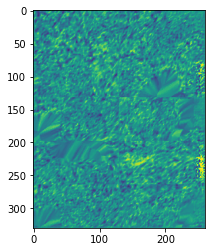

In [16]:
nz=20
G_test=G_update.cpu()
D_test=D_update.cpu()
input_z_t=torch.ones(10,nz*2)
input_z_t=input_z_t.view(-1,nz,2,1)
plt.imshow(G_test(input_z_t)[0][0].detach().numpy())

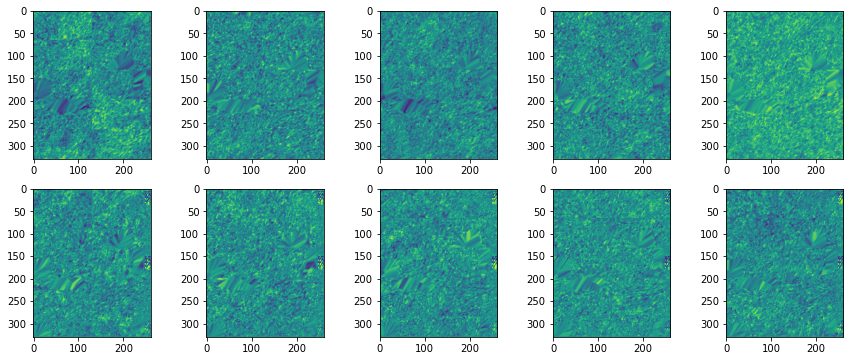

In [28]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#入力の乱数生成
batch_size=8
nz=20
fixed_z=torch.randn(batch_size,nz*2)
fixed_z=fixed_z.view(batch_size,nz,2,1)

#画像生成
G_test.eval().cpu()
fake_images=G_update(fixed_z)

#訓練データ
batch_iterator=iter(dataloader_train)
imgs=next(batch_iterator)#1番目の要素を取り出す

#出力
fig=plt.figure(figsize=(15,6))
for i in range(0,5):
    #上段に訓練データ
    plt.subplot(2,5,i+1)
    plt.imshow(imgs[i][0].cpu().detach().numpy())
    
    #下段に生成データ
    plt.subplot(2,5,5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy())
    #plt.imshow(images_check[2][i][0].cpu().detach().numpy())

In [17]:
#model_保存
model_G_path="SAGAN_G.pth"
model_D_path="SAGAN_D.pth"
G_test=G_test.to("cpu")
torch.save(G_test.state_dict(),model_G_path)

torch.Size([1, 1, 1])
torch.Size([20, 1, 330, 261])
tensor([[[[2.7906e-05]]],


        [[[2.9170e-05]]],


        [[[2.9731e-05]]],


        [[[2.5077e-05]]],


        [[[2.9888e-05]]],


        [[[2.8497e-05]]],


        [[[3.0244e-05]]],


        [[[2.4899e-05]]]], grad_fn=<SigmoidBackward>)
tensor([[[[0.9992]]],


        [[[0.9996]]],


        [[[0.9994]]],


        [[[1.0000]]],


        [[[1.0000]]],


        [[[1.0000]]],


        [[[1.0000]]],


        [[[1.0000]]],


        [[[1.0000]]],


        [[[0.9999]]],


        [[[1.0000]]],


        [[[0.9999]]],


        [[[0.9995]]],


        [[[1.0000]]],


        [[[1.0000]]],


        [[[1.0000]]],


        [[[1.0000]]],


        [[[1.0000]]],


        [[[1.0000]]],


        [[[1.0000]]]], grad_fn=<SigmoidBackward>)
tensor([[[[3.6836e-09]]],


        [[[9.7124e-09]]],


        [[[6.9861e-09]]],


        [[[8.5771e-09]]],


        [[[7.8389e-09]]],


        [[[6.2949e-09]]],


        [[[2.4343e-08]]]

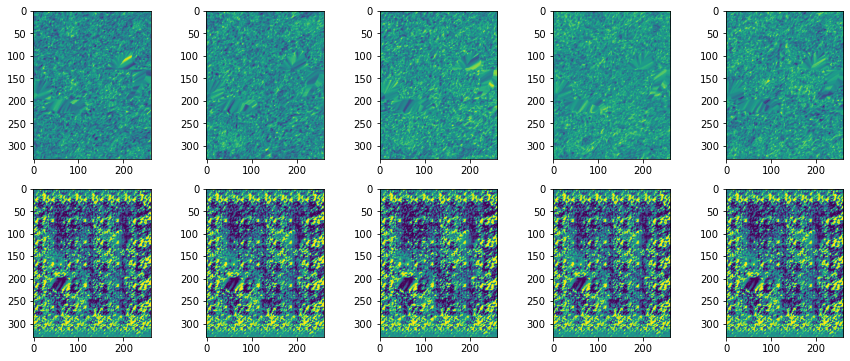

In [44]:
#入力の乱数生成
batch_size=8
nz=20
fixed_z=torch.randn(batch_size,nz*1)
fixed_z=fixed_z.view(batch_size,nz,1,1)

#画像生成
G_update.eval().cpu()
fake_images=G_update(fixed_z)

#訓練データ
batch_iterator=iter(dataloader_train)
imgs=next(batch_iterator)#1番目の要素を取り出す

#出力
fig=plt.figure(figsize=(15,6))
for i in range(0,5):
    #上段に訓練データ
    plt.subplot(2,5,i+1)
    plt.imshow(imgs[i][0].cpu().detach().numpy())
    
    #下段に生成データ
    plt.subplot(2,5,5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy())

#D=Discriminator(DIM=64)####################
D_update.eval().cpu()
d_out=D_update(fake_images.cpu())
d_true=D_update(imgs)
p_500=D_update(images_check[0].cpu().view(-1,1,330,261))
print(d_out[0].shape)
print(images_check[1].shape)
print(nn.Sigmoid()(d_out))#
print(nn.Sigmoid()(d_true))
print(nn.Sigmoid()(p_500))

In [29]:
"""
import matplotlib.pyplot as plt
import time
%matplotlib inline
# 入力する乱数
input_z = torch.randn(1, 400)
# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(1, 20, 5, 4)
# 偽画像を出力
start=time.time()
fake_images= G(input_z)
end=time.time()
print(fake_images.shape)
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed)
plt.show()

print(end-start)
#params_D = 0
params_G=0
#for p in D.parameters():
    #if p.requires_grad:
        #params_D += p.numel()
for p in G.parameters():
    if p.requires_grad:
        params_G += p.numel()
#print((13465803+14664877)/(3173251+2946099))
#print(params_D)  # 121898
print(params_G)

#"""

RuntimeError: Tensor for argument #1 'input' is on CPU, Tensor for argument #2 'output' is on CPU, but expected them to be on GPU (while checking arguments for slow_conv_transpose2d_out_cuda)

In [31]:
def plot_graph(values1, values2, rng, label1, label2):
    plt.plot(range(rng), values1, label=label1)
    plt.plot(range(rng), values2, label=label2)
    plt.legend()
    plt.grid()
    plt.show()

<class 'list'>


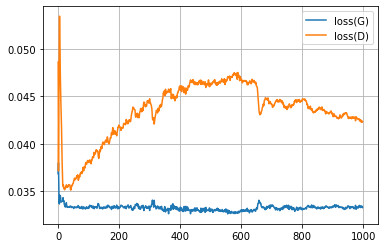

In [32]:
#history_c=history.cpu()
d_loss=history["discriminator_loss_values"].copy()
g_loss=history["generator_loss_values"].copy()
num_epochs_real=len(g_loss)
d_loss_c=[]
g_loss_c=[]
#"""
for i in range(num_epochs_real-1):
    """
    if d_loss[i+1]>100:
        d_loss[i+1]=100
    if g_loss[i+1]>100:
        g_loss[i+1]=100
    """
    dc=(d_loss[i]+d_loss[i+1])/(2*num_epochs_real)
    gc=(g_loss[i]+g_loss[i+1])/(2*num_epochs_real)
    d_loss_c.append(dc)
    g_loss_c.append(gc)
#"""
print(type(d_loss))
plot_graph(g_loss_c,d_loss_c,num_epochs_real-1,"loss(G)","loss(D)")

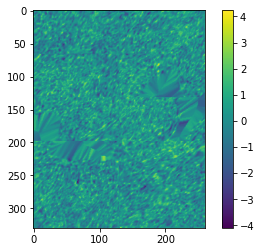

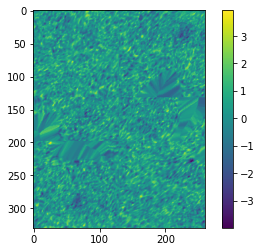

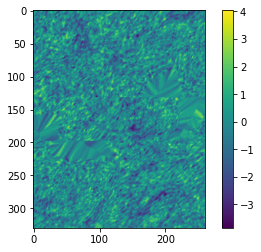

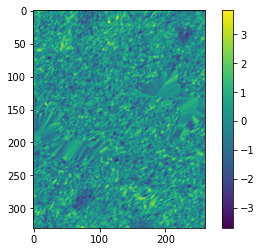

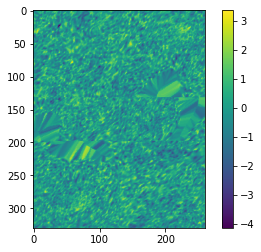

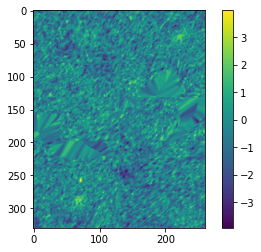

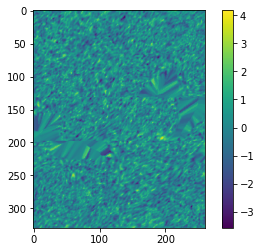

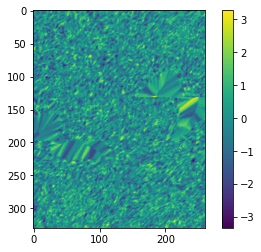

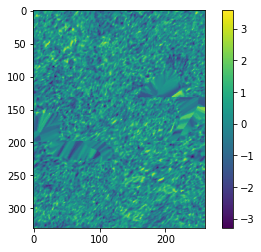

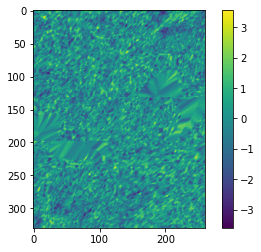

In [36]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader_valid))

# Plot the real images
#plt.axis("off")
#plt.title("Real Images")
#print(float(real_batch[1][0][330][1]))
"""d_sum=0
for i in range(330):
    for j in range(261):
        a=((int(real_batch[1][0][i][j]*1000)-int(real_batch[0][0][i][j]*1000))/1000)**2
        d_sum+=a
        if a<0:
            print("error")
print(d_sum)
"""
for i in range(10):
    plt.imshow(real_batch[i][0])
    plt.colorbar()
    plt.show()

In [14]:
"""学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """
"""
def make_datapath_list():
    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(5):
        img_path = "./data/true_data/" + str(img_idx)+'.pt'
        train_img_list.append(img_path)
    return train_img_list"""

'\ndef make_datapath_list():\n    train_img_list = list()  # 画像ファイルパスを格納\n\n    for img_idx in range(5):\n        img_path = "./data/true_data/" + str(img_idx)+\'.pt\'\n        train_img_list.append(img_path)\n    return train_img_list'

In [18]:
"""画像の前処理クラス"""
"""
class ImageTransform():
    

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)"""

In [6]:
"""画像のDatasetクラス。PyTorchのDatasetクラスを継承"""
"""
class GAN_Img_Dataset(data.Dataset):
    

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed
"""

"\nclass GAN_Img_Dataset(data.Dataset):\n    \n\n    def __init__(self, file_list, transform):\n        self.file_list = file_list\n        self.transform = transform\n\n    def __len__(self):\n        '''画像の枚数を返す'''\n        return len(self.file_list)\n\n    def __getitem__(self, index):\n        '''前処理をした画像のTensor形式のデータを取得'''\n\n        img_path = self.file_list[index]\n        img = Image.open(img_path)  # [高さ][幅]白黒\n\n        # 画像の前処理\n        img_transformed = self.transform(img)\n\n        return img_transformed\n"

In [100]:
"""
注意事項
過去のコードと異なりz_dim->nzになっています。
image_size(隠れ層での変換後の配列を決める値)->DIMとしています。



class Generator(nn.Module):

    def __init__(self, nz=20, DIM=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(nz, DIM *64,
                                                      kernel_size=3, stride=2,padding=1)),
            nn.BatchNorm2d(DIM * 64),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(DIM * 64, DIM * 16,
                                                      kernel_size=3, stride=2, padding=(0,1))),
            nn.BatchNorm2d(DIM * 16),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(DIM * 16, DIM * 4,
                                                      kernel_size=3, stride=2, padding=1)),
            nn.BatchNorm2d(DIM * 4),
            nn.ReLU(inplace=True))

        # Self-Attention層を追加
        self.self_attntion1 = Self_Attention(in_dim=DIM * 4)

        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(DIM * 4, DIM,
                                                      kernel_size=3, stride=2, padding=1)),
            nn.BatchNorm2d(DIM),
            nn.ReLU(inplace=True))

        # Self-Attention層を追加
        self.self_attntion2 = Self_Attention(in_dim=DIM)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(DIM, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ


    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out#, attention_map1, attention_map2
#"""